# Pipeline

The diffusers library aims to provide easy access to diffusion models and its adapters for gnerations of image and related materials.

The diffusion model has 2 major components:
* unet: responsible to predict noises at each step
* scheduler: used to generate noise at each step in the forward process and remove estimated noise at each step during the backward process.
There are other components depending on the applications.

Pipelines help manage the components and do inference in an integrated manner.

The following sections generate image using components of the pipeline to illustrate how the pipelines work behind the scene.

In [4]:
import torch

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

## I. Diffusion Model

The original diffusion model has only the 2 components mentioned before.
The image is generated by sampling from the image space.

In [2]:
# load unet

from diffusers import UNet2DModel

unet = UNet2DModel.from_pretrained("google/ddpm-celebahq-256").to(device)
unet

An error occurred while trying to fetch google/ddpm-celebahq-256: google/ddpm-celebahq-256 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Con

In [3]:
unet.config

FrozenDict([('sample_size', 256),
            ('in_channels', 3),
            ('out_channels', 3),
            ('center_input_sample', False),
            ('time_embedding_type', 'positional'),
            ('freq_shift', 1),
            ('flip_sin_to_cos', False),
            ('down_block_types',
             ['DownBlock2D',
              'DownBlock2D',
              'DownBlock2D',
              'DownBlock2D',
              'AttnDownBlock2D',
              'DownBlock2D']),
            ('up_block_types',
             ['UpBlock2D',
              'AttnUpBlock2D',
              'UpBlock2D',
              'UpBlock2D',
              'UpBlock2D',
              'UpBlock2D']),
            ('block_out_channels', [128, 128, 256, 256, 512, 512]),
            ('layers_per_block', 2),
            ('mid_block_scale_factor', 1),
            ('downsample_padding', 0),
            ('downsample_type', 'conv'),
            ('upsample_type', 'conv'),
            ('dropout', 0.0),
            ('act_fn', 'si

In [4]:
# load scheduler

from diffusers import DDPMScheduler

scheduler = DDPMScheduler.from_pretrained("google/ddpm-celebahq-256")
scheduler

DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.29.2",
  "beta_end": 0.02,
  "beta_schedule": "linear",
  "beta_start": 0.0001,
  "clip_sample": true,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "variance_type": "fixed_small"
}

In [5]:
# set steps
scheduler.set_timesteps(50)

# show steps
scheduler.timesteps

tensor([980, 960, 940, 920, 900, 880, 860, 840, 820, 800, 780, 760, 740, 720,
        700, 680, 660, 640, 620, 600, 580, 560, 540, 520, 500, 480, 460, 440,
        420, 400, 380, 360, 340, 320, 300, 280, 260, 240, 220, 200, 180, 160,
        140, 120, 100,  80,  60,  40,  20,   0])

In [6]:
# manual denoise

image_size = unet.config.sample_size
generator = torch.manual_seed(42)
noisy_image = torch.randn((1, 3, image_size, image_size), generator=generator, device=device)

for t in scheduler.timesteps:

    with torch.inference_mode():
        noise = unet(noisy_image, t).sample

    prev_image = scheduler.step(noise, t, noisy_image).prev_sample
    noisy_image = prev_image

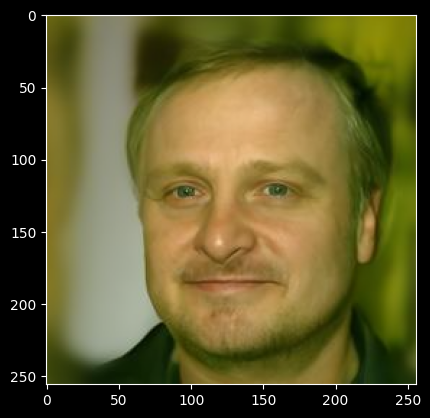

In [7]:
# rescale
# the output image's values are between -1 and 1, so we first rescale it to (0,1)
# then, we convert the float values to int8 as image
image = ((noisy_image.squeeze().permute(1, 2, 0) + 1.0) / 2.0).clamp(0, 1)
image = (image * 255).round().to(torch.uint8).cpu().numpy()

# show image
import matplotlib.pyplot as plt

plt.imshow(image)

diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /home/niuniu/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /home/niuniu/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

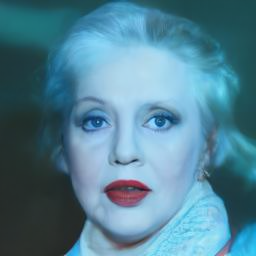

In [8]:
# pipeline for DDPM

# pipeline will takes care of the above steps

# we can download directly from the HF repo

from diffusers import DDPMPipeline

pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256").to(device)

images = pipe(num_inference_steps=50, generator=generator)

images[0][0]


  0%|          | 0/50 [00:00<?, ?it/s]

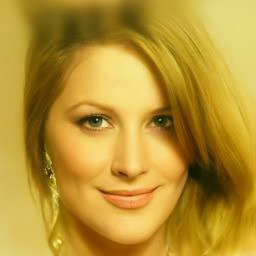

In [9]:
# or we can use the already downloaded model and scheduler

pipe = DDPMPipeline(unet, scheduler=scheduler)

images = pipe(num_inference_steps=50)

images[0][0]


## II. Stable diffusion model

Stable diffusion models has the same core components as diffusion model mentioned above. But:
 * instead of the whole image space, it wrks on the latent space of the image which has lower dimension. So it has an encoder to encode the image and a decoder to reconstruct the image.
 * a text to image model can also be used to encode the image, so we may need a tokenizer and a text encoder.

So the stable diffusion model is also called text-to-image latent diffusion model.

In [2]:
ckp = "CompVis/stable-diffusion-v1-4"

#### UNet

Different from the unet used previously, this unet is a conditional model, which means that the unet takes other inputs other than the image space data and the time steps, it can takes other inputs such as text, other images...
But they should be embedded beforhand to be injected into the attension layers along with time steps.

In [ ]:
# load model

from diffusers import UNet2DConditionModel

# unlike before that the model is in the repo root, we need to indicate the subfolder  
# since the model was in a folder in the repo.
# All files and subfolders can be found: https://huggingface.co/CompVis/stable-diffusion-v1-4/tree/main

# also, there is model in safetensor, so we download this version

# The loaded model has 4 channels for the inputs.

unet = UNet2DConditionModel.from_pretrained(ckp, subfolder="unet", use_safetensors=True)
unet

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

#### Scheduler

In [12]:
# download scheduler

from diffusers import PNDMScheduler, UniPCMultistepScheduler

scheduler = UniPCMultistepScheduler.from_pretrained(ckp, subfolder="scheduler", use_safetensors=True)

#### VAE

VAE is a model to encode the input into a more compressed form - latent space - to feed into the unet. It allows to make faster generation and to save memory.
It is composed of a encoder and a decoder. The encoder compresses the input and the decoder decodes the unet output into image.

In [ ]:
# download vae to encode and decoder images

from diffusers import AutoencoderKL

vae = AutoencoderKL.from_pretrained(ckp, subfolder="vae", use_safetensors=True)

In [ ]:
# example

# notes:
#   - the model drease the image dimension by 8 fold
#   - but it returns a latent space with 4 channels
#   - 0.18215 is a scale factor for the diffusion model
#   

image = torch.rand(2, 3, 1024, 1024) * 2 - 1

with torch.inference_mode():
    latents = vae.encode(image).latent_dist.mean * 0.18215
    output = vae.decode(latents / 0.18215).sample

print(image.shape, latents.shape, output.shape)


torch.Size([2, 3, 1024, 1024]) torch.Size([2, 4, 128, 128]) torch.Size([2, 3, 1024, 1024])


#### Text encoder

This uses the transformers module. For details, refer to the transformers tutorials.

In [14]:
# load tokenizer

from transformers import CLIPTokenizer

tokenizer = CLIPTokenizer.from_pretrained(ckp, subfolder="tokenizer", use_safetensors=True)
tokenizer

CLIPTokenizer(name_or_path='CompVis/stable-diffusion-v1-4', vocab_size=49408, model_max_length=77, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|startoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	49406: AddedToken("<|startoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	49407: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}

In [15]:
# load encoder

from transformers import CLIPTextModel

encoder = CLIPTextModel.from_pretrained(ckp, subfolder="text_encoder", use_safetensors=True)
encoder

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e

#### Manual Sampling

In [16]:
# generate

prompt = ["a picture of black and white cat eating a big red fish."]

width, height = 512, 512

inference_steps = 50

guidance_scale = 7.5

generator = torch.manual_seed(42)

batch_size = len(prompt)

In [ ]:
# tokenize prompt

tokenized_prompt = tokenizer(prompt, max_length=tokenizer.model_max_length, truncation=True, padding="max_length", return_tensors="pt")
tokenized_prompt

{'input_ids': tensor([[49406,   320,  1674,   539,  1449,   537,  1579,  2368,  4371,   320,
          1205,   736,  2759,   269, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]])}

In [ ]:
# encode tokens

with torch.inference_mode():
    encoded_prompt = encoder(tokenized_prompt.input_ids.to(device))
encoded_prompt

BaseModelOutputWithPooling(last_hidden_state=tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 0.6942,  0.3538,  1.0991,  ..., -1.5716, -1.2643, -0.0121],
         ...,
         [-1.0696,  0.6748,  0.4533,  ..., -0.3080, -0.5682, -0.8086],
         [-1.0804,  0.6744,  0.4500,  ..., -0.3328, -0.5689, -0.8267],
         [-1.0592,  0.6673,  0.4806,  ..., -0.2959, -0.5682, -0.8454]]]), pooler_output=tensor([[-9.0280e-01,  3.6188e-01,  2.3772e-01, -1.9236e+00, -9.6828e-01,
          5.8848e-01,  1.1711e+00,  1.1190e+00,  7.2320e-01, -2.8817e-01,
         -7.6353e-01,  3.4456e-01, -1.6888e+00, -4.4392e-01, -2.1117e-01,
          4.8909e-01, -7.2388e-01, -6.6219e-01,  4.2418e-01,  1.5324e+00,
          3.6119e-01,  2.0153e-01, -1.1249e+00, -2.8999e-01,  7.0751e-01,
         -1.8060e+00,  2.5425e-01, -1.1461e+00,  5.8243e-01,  1.7051e-01,
         -6.7171e-01, -2.1887e-01, -1.2722e-01, -1.057

In [ ]:
# tokenize unconditional prompt

tokenized_uncond = tokenizer([""]*batch_size, max_length=tokenizer.model_max_length, truncation=True, padding="max_length", return_tensors="pt")
tokenized_uncond

{'input_ids': tensor([[49406, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]]), 'attention_mask': tensor([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]])}

In [ ]:
# encode unconditional prompt

with torch.inference_mode():
    encoded_uncond = encoder(tokenized_uncond.input_ids.to(device))

encoded_uncond

BaseModelOutputWithPooling(last_hidden_state=tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [-0.3711, -1.4497, -0.3401,  ...,  0.9489,  0.1867, -1.1034],
         [-0.5107, -1.4629, -0.2926,  ...,  1.0419,  0.0701, -1.0284],
         ...,
         [ 0.5006, -0.9552, -0.6610,  ...,  1.6013, -1.0622, -0.2191],
         [ 0.4988, -0.9451, -0.6656,  ...,  1.6467, -1.0858, -0.2088],
         [ 0.4923, -0.8124, -0.4912,  ...,  1.6108, -1.0174, -0.2484]]]), pooler_output=tensor([[-3.7112e-01, -1.4497e+00, -3.4011e-01, -1.0820e-01, -1.4188e+00,
          3.1752e-01, -1.8571e-01, -2.3674e-01, -1.1044e+00,  9.0634e-01,
         -6.7430e-01,  8.8501e-01,  2.3569e+00, -5.3967e-01,  4.1692e-01,
          8.4393e-02, -1.5438e+00,  1.8802e+00, -3.1700e-01, -2.3928e-01,
         -1.1967e+00,  1.6942e+00, -1.4265e+00, -6.4020e-01, -5.6384e-01,
          9.8448e-01,  7.3632e-01, -1.4914e+00, -5.0300e-01, -2.0890e-01,
         -1.8133e+00,  7.1496e-01, -1.0035e+00, -1.673

In [21]:
# concat all texts
text_input = torch.cat([encoded_uncond[0], encoded_prompt[0]])

In [22]:
# noise
latents = torch.randn((batch_size, unet.config.in_channels, height//8, width//8), generator=generator, device=device)

# latent scale
latents = latents * scheduler.init_noise_sigma

In [23]:
# generate loop

from tqdm.notebook import tqdm

scheduler.set_timesteps(inference_steps)
noisy_latents = latents

for t in tqdm(scheduler.timesteps):

    # expand the latents when doing classifier-free guidance to avoid doing two forward passes.
    latent_input = torch.cat([noisy_latents] * 2)
    latent_input = scheduler.scale_model_input(latent_input, timestep=t)

    # predict noise
    with torch.inference_mode():
        noise_pred = unet(latent_input, t, encoder_hidden_states=text_input).sample
    
    # guidance
    noise_uncond, noise_text = noise_pred.chunk(2)
    noise_pred = noise_uncond + guidance_scale * (noise_text - noise_uncond)

    # compute previous step
    noisy_latents = scheduler.step(noise_pred, t, noisy_latents).prev_sample

  0%|          | 0/50 [00:00<?, ?it/s]

In [24]:
# decode latent

noisy_latents = noisy_latents / 0.18215

with torch.inference_mode():
    noisy_image = vae.decode(noisy_latents).sample

print(noisy_image.size())

[W NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.


torch.Size([1, 3, 512, 512])


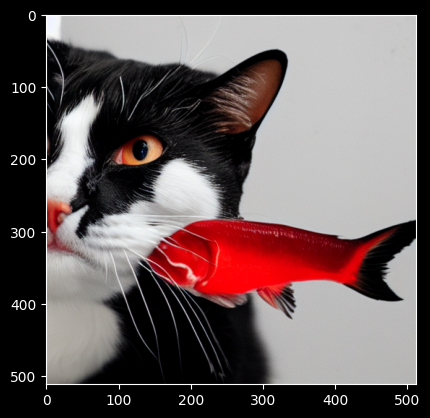

In [25]:
# scale image

image = ((noisy_image.squeeze().permute(1, 2, 0) + 1.0) / 2.0).clamp(0, 1)
image = (image * 255).round().to(torch.uint8).cpu().numpy()

# show image
import matplotlib.pyplot as plt

plt.imshow(image)

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

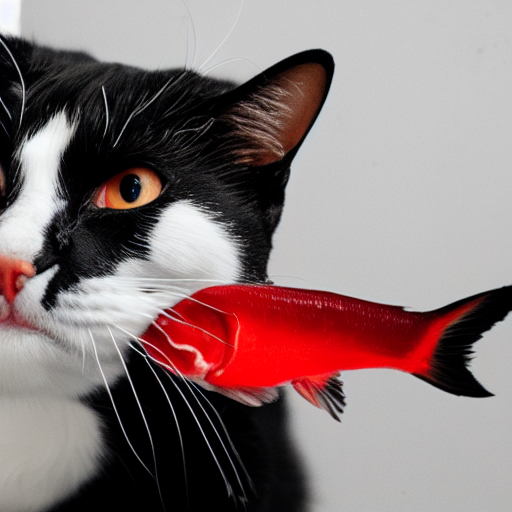

In [26]:
# pipeline for stable diffuser

from diffusers import StableDiffusionPipeline

generator = torch.manual_seed(42)

pipe = StableDiffusionPipeline(vae=vae, text_encoder=encoder, tokenizer=tokenizer, unet=unet, scheduler=scheduler, safety_checker=None, feature_extractor=None).to(device)

images = pipe(prompt[0], num_inference_steps=50, generator=generator)

images[0][0]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

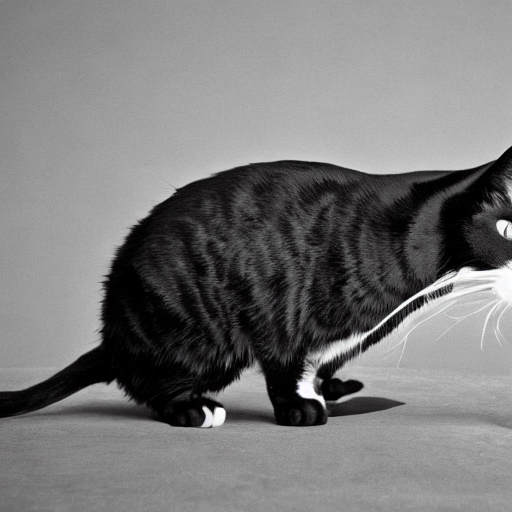

In [27]:
# pipeline for stable diffuser

generator = torch.manual_seed(42)

pipe = StableDiffusionPipeline.from_pretrained(ckp).to(device)

images = pipe(prompt[0], num_inference_steps=inference_steps, generator=generator)

images[0][0]


## III. AutoPipeline

For simplicity, HF provides task-oriented pipeline to use models. It detects automatically the pipeline to call depending on the class.

In [28]:
from diffusers import AutoPipelineForText2Image

pipe_text2img = AutoPipelineForText2Image.from_pretrained("hakurei/waifu-diffusion", use_safetensors=True).to(device)

/home/niuniu/Documents/DL_pytorch/diffuser/lib64/python3.12/site-packages/diffusers/models/vq_model.py:20: FutureWarning: `VQEncoderOutput` is deprecated and will be removed in version 0.31. Importing `VQEncoderOutput` from `diffusers.models.vq_model` is deprecated and this will be removed in a future version. Please use `from diffusers.models.autoencoders.vq_model import VQEncoderOutput`, instead.
  deprecate("VQEncoderOutput", "0.31", deprecation_message)
/home/niuniu/Documents/DL_pytorch/diffuser/lib64/python3.12/site-packages/diffusers/models/vq_model.py:25: FutureWarning: `VQModel` is deprecated and will be removed in version 0.31. Importing `VQModel` from `diffusers.models.vq_model` is deprecated and this will be removed in a future version. Please use `from diffusers.models.autoencoders.vq_model import VQModel`, instead.
  deprecate("VQModel", "0.31", deprecation_message)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

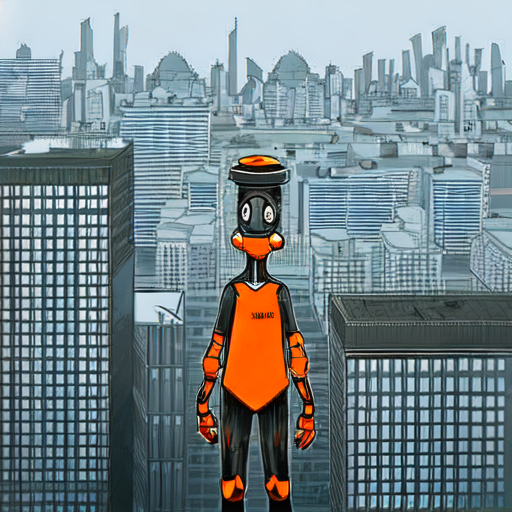

In [29]:
import torch

prompt = "a robotn big eyes, orange harmor, silver head, wired arms, short legs, looking left, city background"
generator = torch.Generator(device="cpu").manual_seed(42)
image = pipe_text2img(prompt, generator=generator)
image[0][0]

## IV. Gradio

In [1]:
import gradio as gr

def generate(text):
    image = pipe_text2img(text)
    return image[0][0]

app = gr.Interface(
    generate,
    inputs = gr.Textbox(),
    outputs= gr.Image(),
)
app.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [ ]:
# check model cache

!ls ~/.cache/huggingface/hub/

models--CompVis--ldm-celebahq-256
models--CompVis--stable-diffusion-v-1-4
models--CompVis--stable-diffusion-v-1-4-original
models--CompVis--stable-diffusion-v1-4
models--CompVis--stable-diffusion-v1-4-original
models--ai-forever--Kandinsky3.1
models--ckpt--stable-diffusion-3-medium
models--diffusers--controlnet-canny-sdxl-1.0
models--google--ddpm-cat-128
models--google--ddpm-cat-256
models--google--ddpm-celebahq-256
models--jameslahm--yolov10s
models--lllyasviel--Annotators
models--lllyasviel--ControlNet
models--lllyasviel--control_v11p_sd15_inpaint
models--lllyasviel--sd-controlnet-canny
models--mattmdjaga--segformer_b2_clothes
models--mrm8488--ddpm-ema-anime-128
models--openai--clip-vit-base-patch32
models--runwayml--stable-diffusion-inpainting
models--runwayml--stable-diffusion-v1-4
models--runwayml--stable-diffusion-v1-5
models--samwit--ddpm-afhq-cats-128
models--stabilityai--sd-vae-ft-mse
models--stabilityai--sdxl-turbo
models--stabilityai--stable-diffusion-2-1
models--stabilityai